In [2]:
import numpy as np
import pandas as pd
import time
import pickle

# For plotting

%matplotlib inline
import random
import networkx
#UMAP
import umap.umap_ as umap
import shap
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

from sklearn.cluster import OPTICS
import numpy as np


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import rcParams
import os
import networkx
import itertools


In [6]:
picklepath = ''
pro_all = pd.read_pickle(picklepath+'pro_all.pickle')
met_all = pd.read_pickle(picklepath+'met_all.pickle')
met_shap = pickle.load( open( picklepath + 'shap_pmet_all.pickle', "rb" ))
shap_values = np.asarray(list(met_shap.values()))


# UMAP

Create UMAP/optics plot as example. Then go through each known compound, repeat UMAP/optics 1000 times and export the clusters formed each time

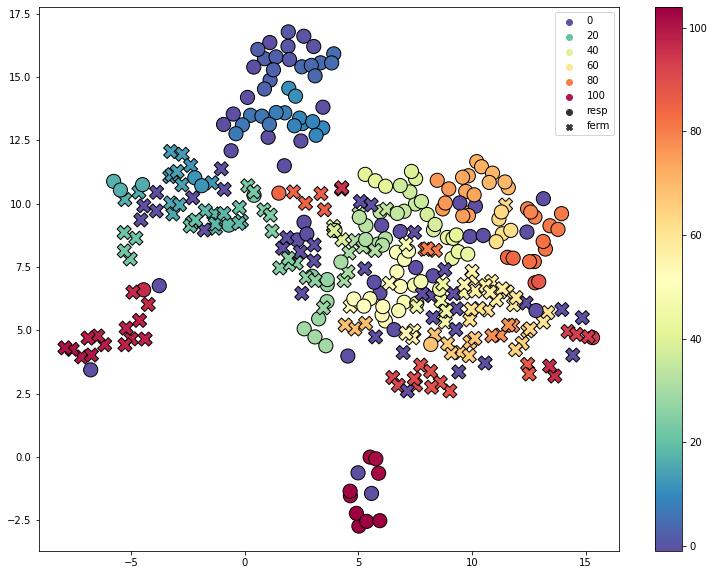

In [7]:
#Create Example UMAP figure

rcParams['figure.figsize'] = 13,10
start = time.time()
y = list(pro_all.index)
x = shap_values[20]

reducer = umap.UMAP(n_components=2,random_state = 42, n_neighbors=4, min_dist = 1, metric='manhattan')
embedding =  reducer.fit_transform(x)

pcx=reducer.embedding_[:, 0]
pcy=reducer.embedding_[:, 1]

i=0


condition = []
for value in list(pro_all.index):
    condition.append(value.split("_")[1])

clustering = OPTICS(min_samples=2).fit(reducer.embedding_)
#sns.scatterplot(x=pcx, y=pcy, hue = colorclusters,
#                style = condition, palette = sns.color_palette("Set2", 100, as_cmap = True), s=200)
#sns.scatterplot(x=x_ribo, y=y_ribo,
#                 palette = sns.color_palette("gray"), s=1)

norm = plt.Normalize(np.array(clustering.labels_).min(), np.array(clustering.labels_).max())
#norm = plt.Normalize(np.array(colorclusters).min(), np.array(colorclusters).max())
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("Spectral_r", 30, as_cmap = True), norm=norm)
sm.set_array([])




kwargs  =   {'edgecolor':"black", # for edge color
             'linewidth':1, # line width of spot
            }

ax = sns.scatterplot(x=pcx, y=pcy, hue = clustering.labels_,#colorclusters,
                style = condition, palette = sns.color_palette("Spectral_r", 30, as_cmap = True), s=200,
                **kwargs)
#ax.get_legend().remove()
ax.figure.colorbar(sm)
#plt.savefig('YJR120W_umap_clusterNOumap.svg')
plt.show()

In [ ]:
#compound loop of umaploop

y = list(pro_all.index)
compound = 0
compoundclustersarray = []
while compound < len(list(met_shap.keys())):
    if compound == 65:
        compound = 265
    x = shap_values[compound]
    #x = pro_all.values
    iterator = 0
    repeats = 1000
    labelarray = []
    nclusters = []
    #x = StandardScaler().fit_transform(x)

    while iterator<repeats:
        reducer = umap.UMAP(n_components=10, n_neighbors=3, min_dist = 0, metric='manhattan')
        embedding =  reducer.fit_transform(x)
        clustering = OPTICS(min_samples=2).fit(reducer.embedding_)
        labelarray.append(clustering.labels_)
        iterator+=1

    clustersarray = []

    i = 0
    while i < len(labelarray):
        j=0
        temp = []
        while j < max(labelarray[i])+1:
            temp.append([])
            j+=1
        j = 0
        while j < len(labelarray[i]):
            if labelarray[i][j] != -1:
                temp[int(labelarray[i][j])].append(y[j])
            j+=1
        for value in temp:
            clustersarray.append(value)
        i+=1
    #compoundclustersarray.append(clustersarray)

    
    pickle.dump( clustersarray, open(picklepath + "clusters\\" + str(compound)+ "-" + str(list(met_shap.keys())[compound].split(" ")[0]) + ".pickle", "wb" ))
    compound+=1
    print(str(compound)+ "-" + str(list(met_shap.keys())[compound].split(" ")[0]))

# Network
Go through clusters generated previously. Create edges between clustered conditions and adjust weight based on times co-clustered

In [9]:
#Create Network with all conditions and connections across metabolites



#Get a list of all clusters from cluster pickles to get cluster overlaps
#create graph containing all connections
files = []
allclusters = []
#allfinalclusters=[]

clusterpath = picklepath + "clusters\\"
files = []
for file in os.listdir(clusterpath):
    path = os.path.join(clusterpath, file)
    if os.path.isdir(path):
        # skip directories
        continue
    else:
        files.append(file)

for value in files:
    allclusters.append(pickle.load( open( clusterpath + value, "rb" )))
G = networkx.Graph()    
compound = 0
while compound < len(allclusters):
    

    i = 0
    while i < len(allclusters[compound]):
        j = 0
        if compound == 0:
            while j < len(allclusters[compound][i]):
                G.add_node(allclusters[compound][i][j])
                j+=1
        j = 0
        while j < len(allclusters[compound][i]):
            k = 0
            while k < len(allclusters[compound][i]):
                if G.has_edge(allclusters[compound][i][j], allclusters[compound][i][k]):
                    # we added this one before, just increase the weight by one
                    G[allclusters[compound][i][j]][allclusters[compound][i][k]]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    G.add_edge(allclusters[compound][i][j], allclusters[compound][i][k], weight=1)
                k+=1
            j+=1
        i+=1
        
    G.remove_edges_from(networkx.selfloop_edges(G))

    print(compound/len(allclusters), end='\r')
    compound+=1
    
#pickle.dump(allfinalclusters, open("allfinalclusters_new.pickle", 'wb'))
networkx.write_graphml(G,"allconnectionsallmetabolites.xml")

In [10]:
#create networks for each metabolites and output weights in csv

nodes_list = list(G.nodes)
combined_nodes_list = itertools.combinations(nodes_list, 2)
combined_nodes_list = list(combined_nodes_list)

edges_list = []

for value in combined_nodes_list:
    edges_list.append(str(value[0]) + " (-) " + str(value[1]))
    
weightsdf = pd.DataFrame()
weightsdf['Edges'] = edges_list
#Get a list of all clusters from cluster pickles to get cluster overlaps
#create graph containing all connections
files = []
allclusters = []
#allfinalclusters=[]

clusterpath = picklepath + "clusters\\"
files = []
for file in os.listdir(clusterpath):
    path = os.path.join(clusterpath, file)
    if os.path.isdir(path):
        # skip directories
        continue
    else:
        files.append(file)

for value in files:
    allclusters.append(pickle.load( open( clusterpath + value, "rb" )))
G = networkx.Graph()    
compound = 0
while compound < len(allclusters):
    Gtemp = networkx.Graph()  

    i = 0
    while i < len(allclusters[compound]):
        j = 0
        if compound == 0:
            while j < len(allclusters[compound][i]):
                G.add_node(allclusters[compound][i][j])
                Gtemp.add_node(allclusters[compound][i][j])
                j+=1
        j = 0
        while j < len(allclusters[compound][i]):
            k = 0
            while k < len(allclusters[compound][i]):
                if G.has_edge(allclusters[compound][i][j], allclusters[compound][i][k]):
                    # we added this one before, just increase the weight by one
                    G[allclusters[compound][i][j]][allclusters[compound][i][k]]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    G.add_edge(allclusters[compound][i][j], allclusters[compound][i][k], weight=1)
                    
                if Gtemp.has_edge(allclusters[compound][i][j], allclusters[compound][i][k]):
                    # we added this one before, just increase the weight by one
                    Gtemp[allclusters[compound][i][j]][allclusters[compound][i][k]]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    Gtemp.add_edge(allclusters[compound][i][j], allclusters[compound][i][k], weight=1)
                k+=1
            j+=1
        i+=1
        
    G.remove_edges_from(networkx.selfloop_edges(G))
    Gtemp.remove_edges_from(networkx.selfloop_edges(G))
    networkx.write_graphml(Gtemp,str(files[compound].split(".")[0])+"_clusterconnections.xml")
    
    #add data to dataframe
    temp_weight_list = []
    for value in edges_list:
        temp_weight_list.append(0)
    
    graph_edges = []
    for value in list(Gtemp.edges.data()):
        temp_edge_str1 = str(value[0]) + " (-) " + str(value[1])
        temp_edge_str2 = str(value[1]) + " (-) " + str(value[0])
        
        if temp_edge_str1 in edges_list:
            temp_weight_list[edges_list.index(temp_edge_str1)] = value[2]['weight']
        elif temp_edge_str2 in edges_list:
            temp_weight_list[edges_list.index(temp_edge_str2)] = value[2]['weight']
        elif temp_edge_str2 == temp_edge_str1:
            a = 0
        else:
        
            print("not found")
            print(temp_edge_str1)
            print(temp_edge_str2)
    
    weightsdf[str(files[compound].split(".")[0])] = temp_weight_list
    print(compound/len(allclusters), end='\r')
    compound+=1
    
#pickle.dump(allfinalclusters, open("allfinalclusters_new.pickle", 'wb'))
weightsdf.to_csv("weightsdf_test.csv")
weightsdf

,Edges,0-2-Aminoadipic,1-2-Aminoheptanedioic,10-5-Methylthioadenosine,11-6-(Dimethylamino)purine,12-Aconitic,13-Adenine,14-Adenosine-5-monophosphate,15-Alanine,16-Aminomalonic,...,59-Serine,6-3-deoxytetronic,60-Succinic,61-Threonine,62-Thymine,63-Tryptophan,64-Tyrosine,7-4-aminobutanoic,8-4-hydroxybenzaldehyde,9-4-hydroxybenzoic
0,∆MDM10_resp (-) ∆ATP2_resp,1606,0,0,0,1862,0,1928,0,744,...,0,2000,1574,0,0,6,1666,142,0,1820
1,∆MDM10_resp (-) ∆MMM1_resp,1614,0,0,0,0,1994,0,0,0,...,670,0,0,0,0,1458,984,0,0,2
2,∆MDM10_resp (-) ∆OCT1_resp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,12,0,0,0,0,364
3,∆MDM10_resp (-) ∆SSQ1_resp,0,0,0,0,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,0
4,∆MDM10_resp (-) ∆RIP1_resp,0,0,0,0,0,0,0,762,1632,...,0,0,0,0,0,848,0,1284,198,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60373,∆EMC6_resp (-) ∆NIF3_ferm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60374,∆EMC6_resp (-) ∆LIP2_ferm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60375,∆AFG1_resp (-) ∆NIF3_ferm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60376,∆AFG1_resp (-) ∆LIP2_ferm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
